<a href="https://colab.research.google.com/github/Vamshi-Nallaguntla/RNN-LSTM-GRU/blob/main/RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive  # Importing the google drive module, I saved the dataset in my google drive
#mounting drive to the colab environment to access the files in the drive
#Google drive will be mounted at '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Defining the file path to the english vocabulary text file I saved in my google drive
file_path_en = '/content/drive/My Drive/DATASET/small_vocab_en.txt'
# Defining the file path to the french vocabulary text file I saved in my google drive
file_path_fr = '/content/drive/My Drive/DATASET/small_vocab_fr.txt'

In [ ]:
import collections                                                  # Importing collections modules for using counters, dictionaries etc
import numpy as np                                                  # Importing library for doing numeric operations
import os                                                           # For file handling tasks
import time                                                         # To measure time related taks
import matplotlib.pyplot as plt # To create graphs
from tensorflow.keras.preprocessing.text import Tokenizer.          # For tokenizing as per the requirement
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to use padding, Used to pad sequences to the same length
from tensorflow.keras.models import Model, Sequential               # for defining models
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM, SimpleRNN #Different RNN types
from tensorflow.keras.layers import Embedding                       # For representing words as vectors
from tensorflow.keras.optimizers import Adam                        # Importing optimizer
from tensorflow.keras.losses import sparse_categorical_crossentropy # Importing sparse categorical cross-entropy loss function commonly used for multi-class classification tasks.
from tensorflow.keras.callbacks import ReduceLROnPlateau            # A callback that reduces learning rate

In [ ]:
def load_data(path):
  # Joins the provided file path into complete file path
    data_file = os.path.join(path)
    # Opens the file at the specified path in read mode ("r"), 'with' ensures the file is properly closed after reading.
    with open(data_file,"r") as f:
        # Reads the entire contents of the file into the lang_data
        lang_data = f.read()

    # Splits the string into a list of lines using '\n' (newline) as the delimiter and returns it.
    return lang_data.split('\n')

In [ ]:
# Load English data by calling load_data function, this will return list of sentences from the text file
english_sentences = load_data(file_path_en)
# Load French data by calling load_data function, this will return list of sentences from the text file
french_sentences = load_data(file_path_fr)
# Print a confirmation message if loaded properly
print('Dataset Loaded')

Dataset Loaded


In [ ]:
# First two sentences in the loaded vocabulary datasets
for sample_i in range(2):
    # print the english sentences at the indices mentioned
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    # print the french sentences at the indices mentioned
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


In [ ]:
# Creating a counter for English words. It first splits each sentence into words and then flattens the list using a list comprehension.
# collections.Counter is used to count the occurrences of each word in the entire English dataset.
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])

# Creating a counter for French words
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

# Printing the total number of words in the English dataset.
print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))  # Printing the number of unique English words
print('10 Most common words in the English dataset:')                 # print the common words
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))  #to print the total number of words in the french dataset
print('{} unique French words.'.format(len(french_words_counter)))    # Print the number of unique french words
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


In [ ]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # Initialize a Tokenizer instance. 'char_level=False' indicates that the tokenizer will work at the word level.
    x_tk = Tokenizer(char_level = False)
    # Fit the tokenizer on the input list of sentences 'x'. This step converts the sentences into sequences of integers where each integer represents a word.
    x_tk.fit_on_texts(x)
    # Convert the input sentences into sequences of integers based on the tokenizer's word index and Return the tokenized sequences and the tokenizer object itself.
    return x_tk.texts_to_sequences(x), x_tk

In [ ]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # If length is not known, find the length of the longest sequence in the input 'x'.
    if length is None:
        length = max([len(sentence) for sentence in x])

    # Use pad_sequences function to pad the sequences in 'x' to the specified length.
    # 'padding="post"' pads the sequences at the end.
    return pad_sequences(x, maxlen = length, padding = 'post')

In [ ]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    # Tokenize the English sentences (x) and store the tokenized data and tokenizer.
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y) # Tokenize the French sentences (x) and store the tokenized data and tokenizer.

    preprocess_x = pad(preprocess_x) # Padding the tokenized english sentences
    preprocess_y = pad(preprocess_y) # Padding the tokenized french sentences

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk # return them

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

max_english_sequence_length = preproc_english_sentences.shape[1]  # To find the maximum length of english sentence
max_french_sequence_length = preproc_french_sentences.shape[1]    # To find the maximum length of french sentence
english_vocab_size = len(english_tokenizer.word_index)+1          # To find the size of english vocabulary, 1 for padding index
french_vocab_size = len(french_tokenizer.word_index)+1            # To find the size of french vocabulary, 1 for padding index

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 200
French vocabulary size: 345


In [ ]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    # Create a dictionary that maps word indices back to words using the tokenizer's word_index. The dictionary is reversed (from id to word). Index 0 is manually set to '<PAD>'.
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>' # Padding in the output sequence

    # Convert the logits into a sequence of predicted word indices using np.argmax.
    # Then map each index to its corresponding word using the index_to_words dictionary.
    # Finally, join the words into a single string with spaces in between and return the result.
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Print confirmation
print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [ ]:
def build_model(model_type, input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-3 # Set the learning rate
    input_seq = Input(shape=input_shape[1:]) # Excluding batch size, input shape

    # Embedding Layer for English input. Size, dimensionality, length of the input sequences
    embedded = Embedding(input_dim=english_vocab_size, output_dim=128, input_length=input_shape[1])(input_seq)

    # Choose RNN type. 2-layers stacked bi-directional and dropout for regularization
    if model_type == 'RNN':
        rnn = Bidirectional(SimpleRNN(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedded)
        rnn = Bidirectional(SimpleRNN(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(rnn)
    elif model_type == 'LSTM':
        rnn = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedded)
        rnn = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(rnn)
    elif model_type == 'GRU':
        rnn = Bidirectional(GRU(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedded)
        rnn = Bidirectional(GRU(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(rnn)

    # TimeDistributed Dense Layer to predict each word at each timestep. This outputs the vocabulary size (French vocabulary) for each timestep.
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)

    # Softmax activation for final output
    output = Activation('softmax')(logits)

    # Compile model
    model = Model(inputs=input_seq, outputs=output)
    model.compile(loss=sparse_categorical_crossentropy, optimizer=Adam(learning_rate), metrics=['accuracy'])  # Optimizer used is Adam

    return model

# The input data is padded to have the same length as the French sentences (output length).
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
# Print input shape
print("Input shape for the model:", tmp_x.shape[1:])

Input shape for the model: (21,)


In [ ]:
import matplotlib.pyplot as plt # to create plots

# Function to plot training error vs training time
def plot_training_error_vs_time(history, training_time, model_name):
    training_error = [1 - acc for acc in history.history['accuracy']] # Error = 1 - Accuracy
    epochs = range(1, len(training_error) + 1)                        # List of epoch numbers
    time_per_epoch = training_time / len(training_error)
    cumulative_time = [epoch * time_per_epoch for epoch in epochs]    # calculate the cummulative time

    plt.figure(figsize=(10, 6))  # Figure Size
    plt.plot(cumulative_time, training_error, label='Training Error')
    plt.xlabel('Training Time (seconds)') # set x-label
    plt.ylabel('Training Error')  # Set y-label
    plt.title(f'{model_name} Training Error vs Training Time')
    plt.legend()
    plt.show()

# Function to plot Training and Testing errors vs Training time
def plot_errors_vs_time(history, training_time, model_name):
    training_error = [1 - acc for acc in history.history['accuracy']]
    validation_error = [1 - val_acc for val_acc in history.history['val_accuracy']]
    epochs = range(1, len(training_error) + 1)                        # list of epoch numbers
    time_per_epoch = training_time / len(training_error)
    cumulative_time = [epoch * time_per_epoch for epoch in epochs]    #cummulative time for each epoch

    plt.figure(figsize=(10, 6))                                       # Figure size
    plt.plot(cumulative_time, training_error, label='Training Error')
    plt.plot(cumulative_time, validation_error, label='Validation Error')
    plt.xlabel('Training Time (seconds)')                             # Set x-label
    plt.ylabel('Error')                                               # Set y-label
    plt.title(f'{model_name} Training and Testing Error vs Training Time')
    plt.legend()
    plt.show()

# Function to plot Training and Testing loss vs epochs
def plot_loss_vs_epochs(history, model_name):
    training_loss = history.history['loss']                           # Extract Training loss
    validation_loss = history.history['val_loss']                     # Extract Testing loss
    epochs = range(1, len(training_loss) + 1)                         # list of epoch numbers

    plt.figure(figsize=(10, 6))                                       # Figure size
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.xlabel('Epochs')                                              # Set x-label
    plt.ylabel('Loss')                                                # Set y-label
    plt.title(f'{model_name} Training and Testing Loss vs Epochs')
    plt.legend()
    plt.show()

In [ ]:
# Function to Train models and plot graphs
def train_and_evaluate_model(model_type, batch_size=64, epochs=150):
    # Build the model based on the model type (GRU, LSTM, RNN)
    model = build_model(model_type, tmp_x.shape, max_french_sequence_length, english_vocab_size, french_vocab_size)

    # Print starting message
    print(f"\nTraining started for the {model_type} model with {epochs} epochs and batch size {batch_size}.")
    start_time = time.time()  # Start timing the training

    # Train the model with learning rate scheduler only
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Fit the model to the training data
    history = model.fit(
        tmp_x,
        preproc_french_sentences,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        callbacks=[reduce_lr]
    )

    end_time = time.time()  # End timing the training
    training_time = end_time - start_time  # Calculate total training time
    print(f"Training ended for the {model_type} model. Time taken: {training_time:.2f} seconds")

    # Plot Graph 1
    plot_training_error_vs_time(history, training_time, model_type)
    # Plot Graph 2
    plot_errors_vs_time(history, training_time, model_type)
    # Plot Graph 3
    plot_loss_vs_epochs(history, model_type)

    # To Generate 10 translations
    print(f"\n Translations using {model_type} model:")
    for i in range(10):
        index = np.random.randint(0, len(tmp_x)) # random selection
        input_seq = tmp_x[index:index+1]  # Get corresponding i/p sequence and make predictions
        prediction = model.predict(input_seq)
        # Convert the predicted logits to French text
        translated_sentence = logits_to_text(prediction[0], french_tokenizer)
        # to Compare retrieve original english sentence
        original_sentence = english_sentences[index]
        print(f"English: {original_sentence}")  # Print the original English sentence
        print(f"French (Predicted): {translated_sentence}") # Print translated sentence
        print()

    # Return the needed metrics
    return history, training_time


Training started for the GRU model with 150 epochs and batch size 64.
Epoch 1/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 196s 109ms/step - accuracy: 0.7338 - loss: 1.1209 - val_accuracy: 0.8855 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 2/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 187s 108ms/step - accuracy: 0.9254 - loss: 0.2321 - val_accuracy: 0.9211 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 3/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 187s 109ms/step - accuracy: 0.9453 - loss: 0.1693 - val_accuracy: 0.9355 - val_loss: 0.2197 - learning_rate: 0.0010
Epoch 4/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 187s 108ms/step - accuracy: 0.9537 - loss: 0.1445 - val_accuracy: 0.9419 - val_loss: 0.2048 - learning_rate: 0.0010
Epoch 5/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 187s 108ms/step - accuracy: 0.9592 - loss: 0.1280 - val_accuracy: 0.9481 - val_loss: 0.1824 - learning_rate: 0.0010
Epoch 6/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 186s 108ms/step - accuracy: 0.9623 - loss: 0.1182 - val_accuracy: 0.9509 - val_loss: 0.1719

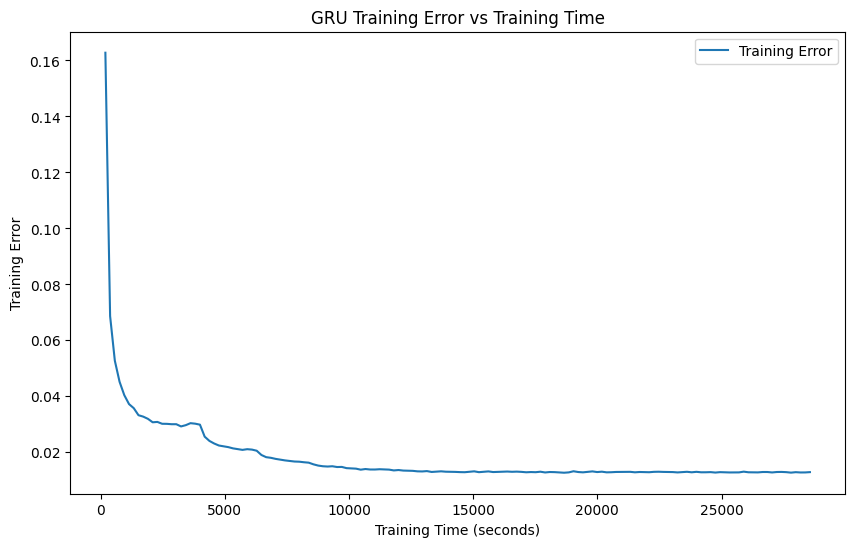

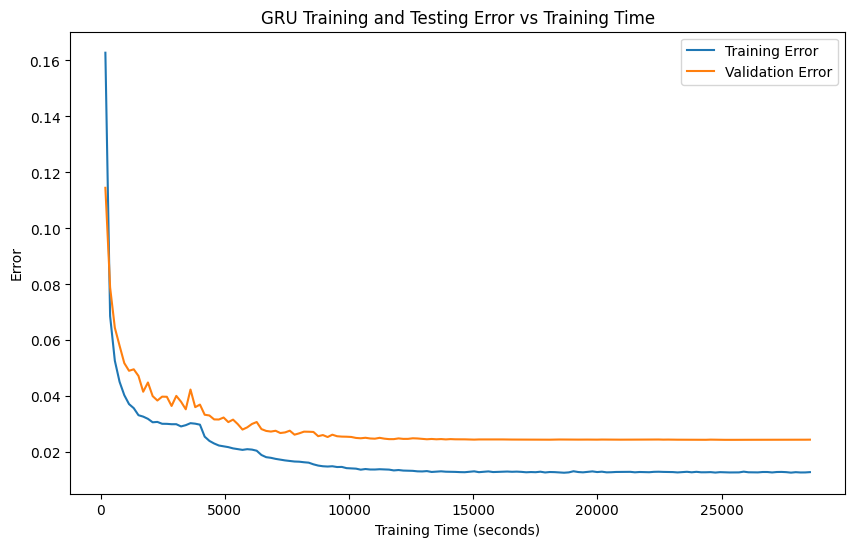

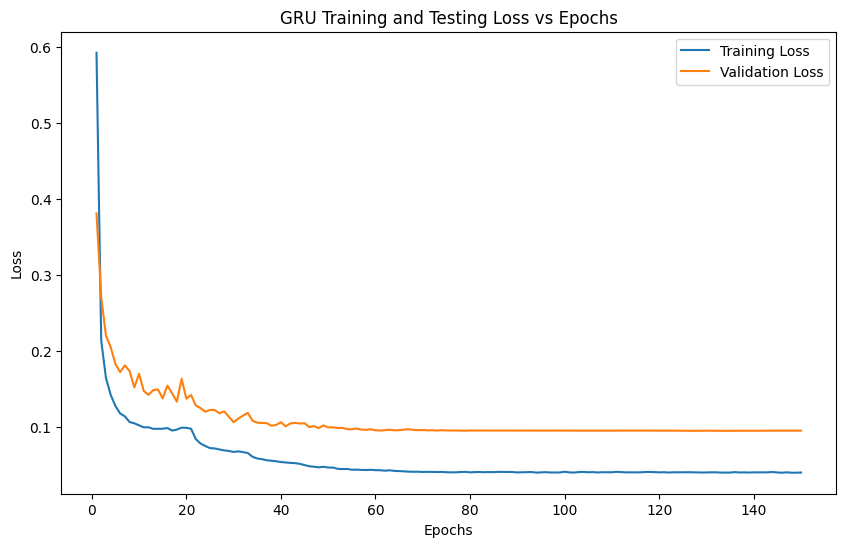


 Translations using GRU model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
English: they like bananas , grapes , and strawberries .
French (Predicted): ils aiment les bananes les raisins et les fraises <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
English: france is wonderful during april , and it is sometimes hot in autumn .
French (Predicted): france est merveilleux en avril et il est parfois chaud à l' automne <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
English: china is relaxing during fall , and it is usually warm in august .
French (Predicted): chine est relaxant à l'automne et il est habituellement chaud en août <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
English: france is sometimes busy during august , but it is never snowy in april .
French (Predicted): la france est parfois occupé au mois d' août mais jamais de neige en avri

In [ ]:
# Training the GRU model and Evaluating it
gru_history, gru_time = train_and_evaluate_model('GRU')


Training started for the LSTM model with 150 epochs and batch size 64.
Epoch 1/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 162s 89ms/step - accuracy: 0.6648 - loss: 1.4085 - val_accuracy: 0.9063 - val_loss: 0.3017 - learning_rate: 0.0010
Epoch 2/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 154s 89ms/step - accuracy: 0.9094 - loss: 0.2846 - val_accuracy: 0.9450 - val_loss: 0.1683 - learning_rate: 0.0010
Epoch 3/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 155s 90ms/step - accuracy: 0.9417 - loss: 0.1774 - val_accuracy: 0.9614 - val_loss: 0.1183 - learning_rate: 0.0010
Epoch 4/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 154s 89ms/step - accuracy: 0.9555 - loss: 0.1338 - val_accuracy: 0.9690 - val_loss: 0.0948 - learning_rate: 0.0010
Epoch 5/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 155s 90ms/step - accuracy: 0.9651 - loss: 0.1063 - val_accuracy: 0.9733 - val_loss: 0.0837 - learning_rate: 0.0010
Epoch 6/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 153s 89ms/step - accuracy: 0.9699 - loss: 0.0914 - val_accuracy: 0.9769 - val_loss: 0.0736 - le

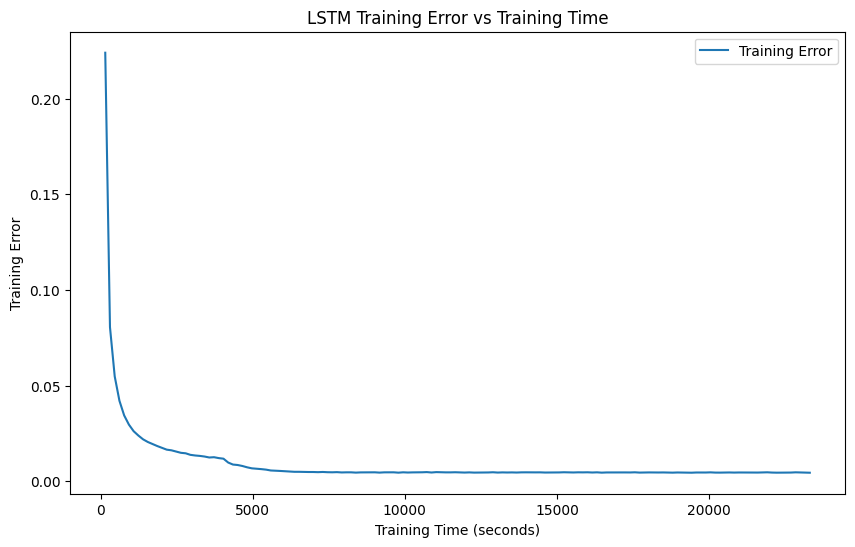

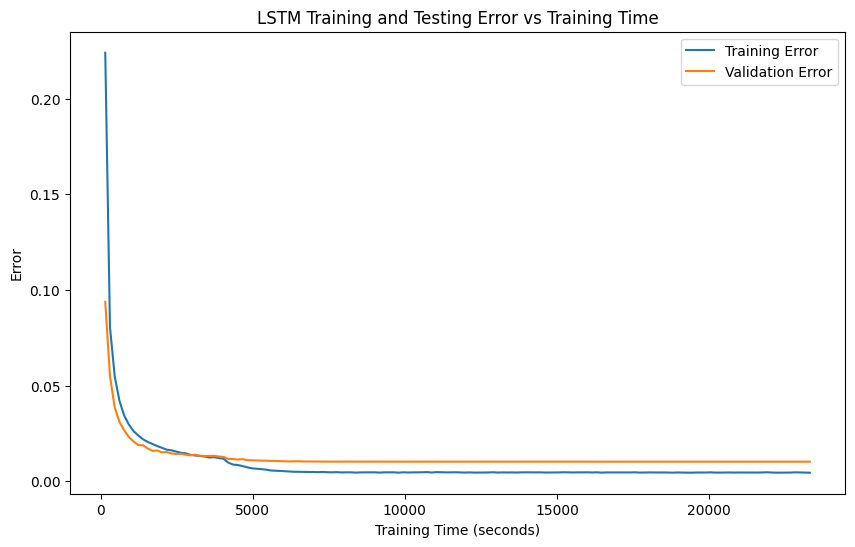

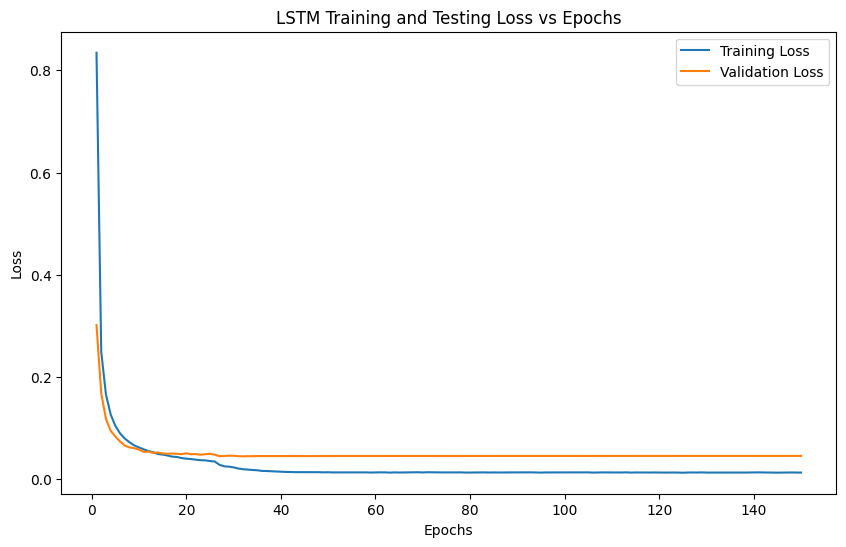


 Translations using LSTM model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
English: paris is chilly during may , and it is never busy in december .
French (Predicted): paris est froid au mois de mai et il est jamais occupé en décembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
English: california is sometimes rainy during august , and it is usually mild in december .
French (Predicted): californie est parfois pluvieux au mois d' août et il est généralement doux en décembre <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
English: the grapefruit is your least favorite fruit , but the grape is their least favorite .
French (Predicted): le pamplemousse est votre fruit préféré moins mais le raisin est leur moins préféré <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
English: the mango is their favorite fruit , but the pear is his favorite .
French (Predicted): la mangue est leur fruit préféré mai

In [ ]:
# Training the LSTM model and Evaluating it
lstm_history, lstm_time = train_and_evaluate_model('LSTM')


Training started for the RNN model with 150 epochs and batch size 64.
Epoch 1/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 76s 34ms/step - accuracy: 0.7019 - loss: 1.2426 - val_accuracy: 0.9080 - val_loss: 0.3000 - learning_rate: 0.0010
Epoch 2/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8942 - loss: 0.3480 - val_accuracy: 0.9289 - val_loss: 0.2311 - learning_rate: 0.0010
Epoch 3/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9131 - loss: 0.2795 - val_accuracy: 0.9379 - val_loss: 0.1971 - learning_rate: 0.0010
Epoch 4/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9226 - loss: 0.2472 - val_accuracy: 0.9441 - val_loss: 0.1803 - learning_rate: 0.0010
Epoch 5/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9280 - loss: 0.2302 - val_accuracy: 0.9490 - val_loss: 0.1617 - learning_rate: 0.0010
Epoch 6/150
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9312 - loss: 0.2205 - val_accuracy: 0.9523 - val_loss: 0.1547 - learning_

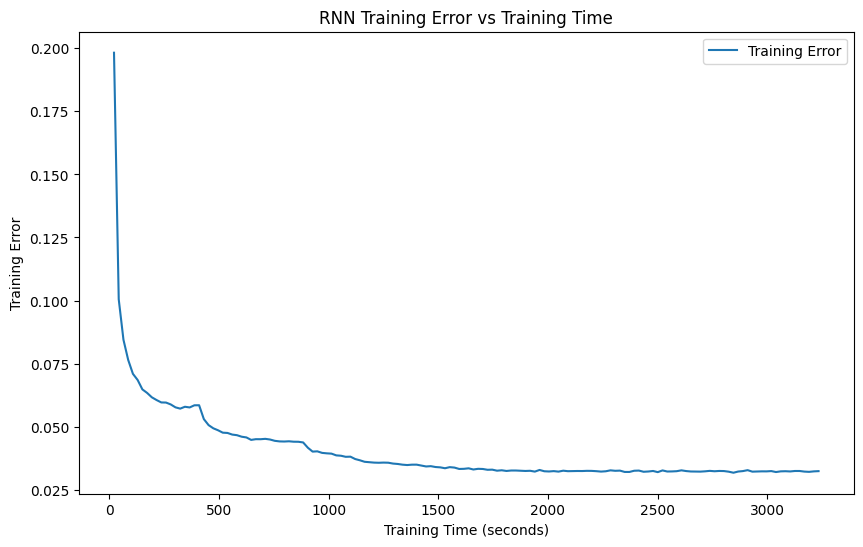

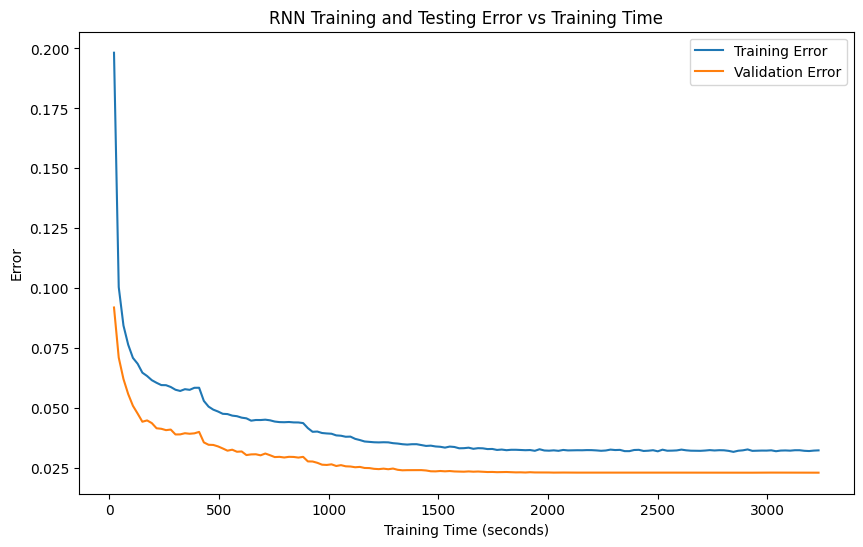

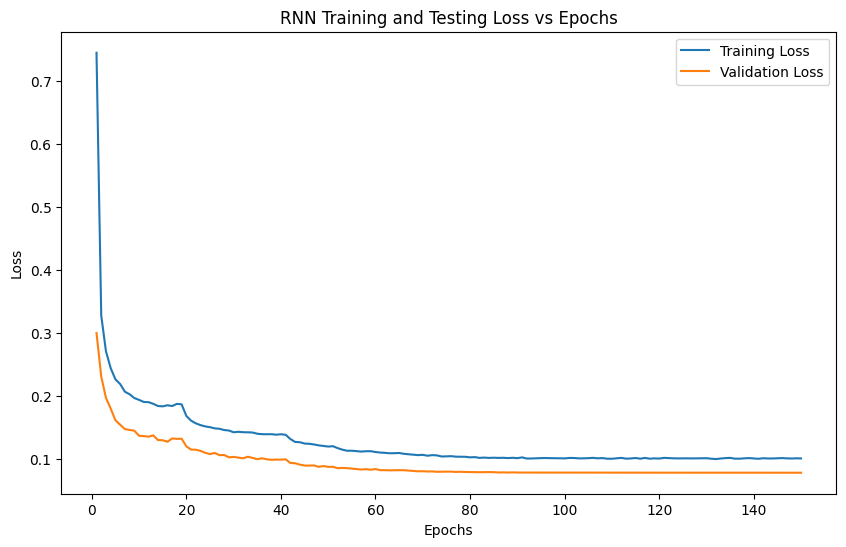


 Translations using RNN model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
English: the apple is his least liked fruit , but the mango is my least liked .
French (Predicted): la pomme est son moins aimé des mais la mangue est mon moins aimé <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
English: the apple is his least favorite fruit , but the banana is her least favorite .
French (Predicted): la pomme est son fruit préféré moins mais la banane est la moins préférée <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English: he dislikes lemons , bananas , and grapefruit.
French (Predicted): il déteste les citrons les bananes et le pamplemousse <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
English: china is usually hot during september , and it is usually cold in january .
French (Predicted): chine est généralement chaud en septembre et il est généralement froid en ja

In [ ]:
# Training the RNN model and Evaluating it
rnn_history, rnn_time = train_and_evaluate_model('RNN')

In [ ]:
# Reporting the accuracies of the models
print(f"GRU Model Testing Accuracy: {max(gru_history.history['val_accuracy']) * 100:.2f}%")    #GRU Model
print(f"LSTM Model Testing Accuracy: {max(lstm_history.history['val_accuracy']) * 100:.2f}%")  #LSTM Model
print(f"RNN Model Testing Accuracy: {max(rnn_history.history['val_accuracy']) * 100:.2f}%")    #RNN Model

GRU Model Testing Accuracy: 97.55%
LSTM Model Testing Accuracy: 98.98%
RNN Model Testing Accuracy: 97.69%
